# PCA on digit recognition data

***Python Data Science Handbook:*** https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb

***Principal Component Analysis and k-means Clustering to Visualize a High Dimensional Dataset:*** https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

In [0]:
import numpy as np
import pandas as pd
import pylab as py
from itertools import cycle
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display, HTML
import seaborn as sns; sns.set()
%matplotlib inline
%config InlineBackend.figure_format='retina'

The goal is to better understand how PCA can be used for data compression, visualization, and improved classification. 


In [0]:
digits = load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

print(f"data shape: {X.shape}, target shape: {y.shape}\nclasses: {list(np.unique(y))}\nn_samples = {n_samples}\nn_features = {n_features}")

data shape: (1797, 64), target shape: (1797,)
classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_samples = 1797
n_features = 64


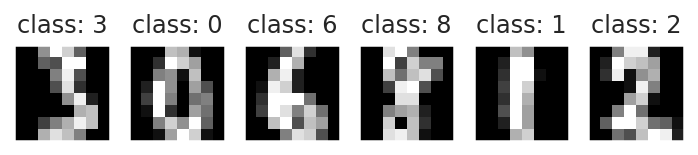

In [0]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        py.subplot(1, data.shape[0], (i + 1))
        py.imshow(data[i].reshape(shape), interpolation=interpolation)
        py.title(labels[i])
        py.xticks(()), py.yticks(())
        py.gray()

subsample = np.random.permutation(X.shape[0])[:6]
images = X[subsample]
labels = ['class: %d' % l for l in y[subsample]]
plot_gallery(images, labels, shape=(8, 8))

1. **Information in the first two components:** Print the percent variance explained for each PCA component, from the first to the last (decreasing).
 - Note how little information is in the first two used for plotting.  
    - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

      - *explained_variance_ratio_*: array, shape (n_components,)
Percentage of variance explained by each of the selected components.
 - As it turns out, RandomizePCA() was depreciated in an older version of SKLearn and is simply a parameter in PCA().
    - https://stackoverflow.com/questions/54494785/sklearn-0-20-2-import-error-with-randomizedpca

In [0]:
pca = RandomizedPCA(n_components = X.shape[1])
pca.fit(X)
X_transformed = pca.transform(X)

print(list(pca.explained_variance_ratio_.round(3)),)

[0.149, 0.136, 0.118, 0.084, 0.058, 0.049, 0.043, 0.037, 0.034, 0.031, 0.024, 0.023, 0.018, 0.018, 0.015, 0.014, 0.013, 0.012, 0.01, 0.009, 0.009, 0.008, 0.008, 0.007, 0.007, 0.006, 0.006, 0.005, 0.005, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


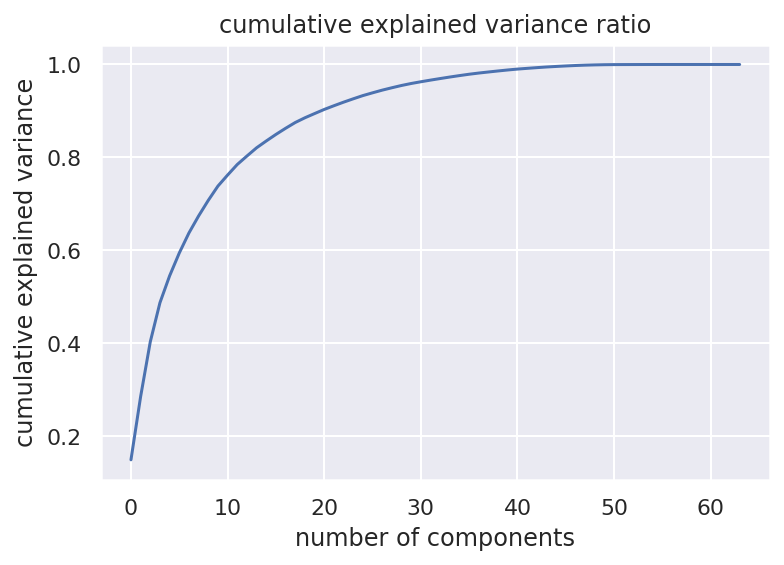

In [0]:
pca = RandomizedPCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_)), plt.title('cumulative explained variance ratio') 
plt.xlabel('number of components'), plt.ylabel('cumulative explained variance');

2. **Understanding a PCA component:** Indicate in writing in the notebook which of the plotted PCA components is most useful for discriminating a $0$ from a $1$ (the first, second, third…?), and how you can observe that in both the samples in the reduced dimensionality plot and the picture of the component itself.

  - Recall that the data consists of $8×8$ pixel images, meaning that they are $64$-dimensional. To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

Text(0, 0.5, 'variance %')

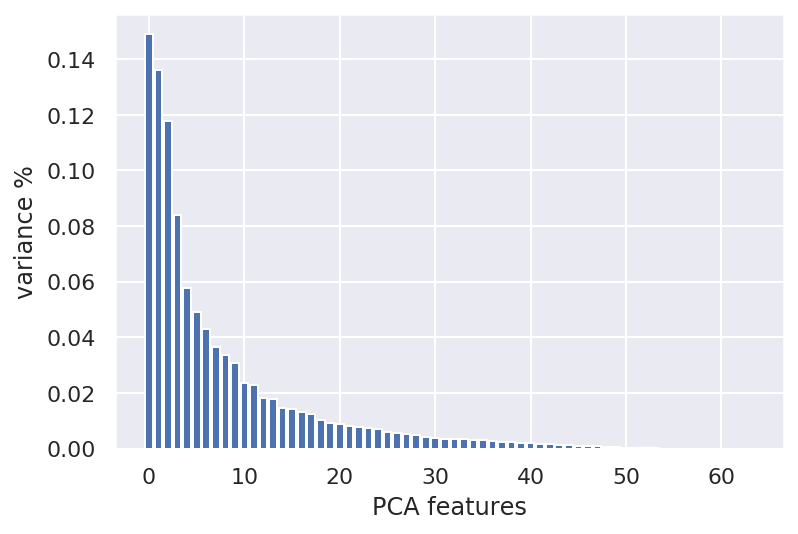

In [0]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')

- The second component shows the greatest gap in variance from the third component distinguishing it as the most significant component for making discrimination. 

In [0]:
def plot_pca_components(x, coefficients=None, mean=0, components=None, imshape=(8, 8), n_components=8, fontsize=10, show_mean=True):
    if coefficients is None:
        coefficients = x
    if components is None:
        components = np.eye(len(coefficients), len(x))
    mean = np.zeros_like(x) + mean
    fig = plt.figure(figsize=(1.2 * (5 + n_components), 1.2 * 2))
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)
    
    def show(i, j, x, title=None):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest')
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "True")
    approx = mean.copy()
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        approx = approx + coefficients[i] * components[i]
        show(0, i + counter, components[i], r'$c_{0}$'.format(i + 1))
        show(1, i + counter, approx, r"${0:.2f} \cdot c_{1}$".format(coefficients[i], i + 1))
        if show_mean or i > 0:
            plt.gca().text(0, 1.05, '$+$', ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=fontsize)
    show(slice(2), slice(-2, None), approx, "Approx")
    return fig

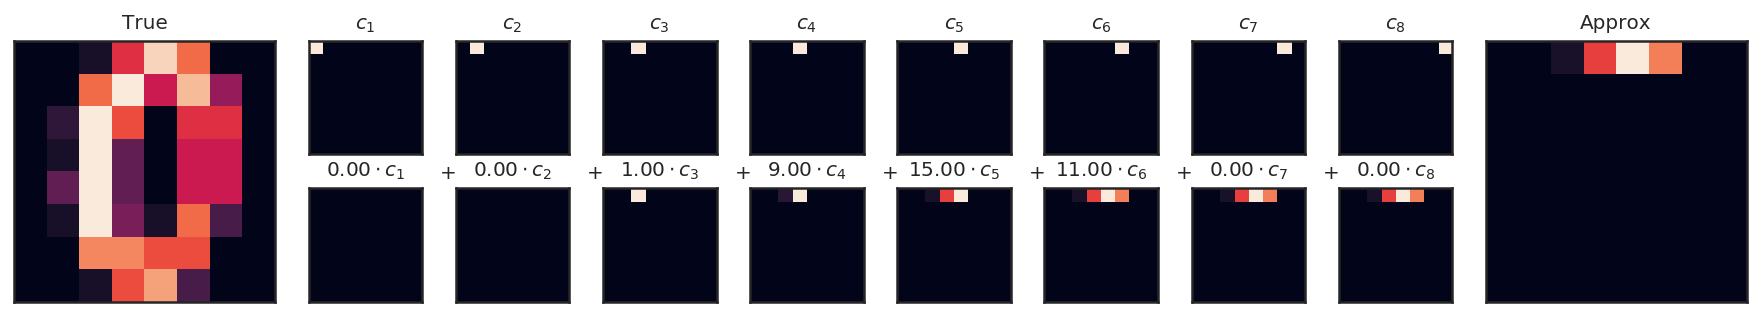

In [0]:
sns.set_style('white')
fig = plot_pca_components(digits.data[10], show_mean=False)

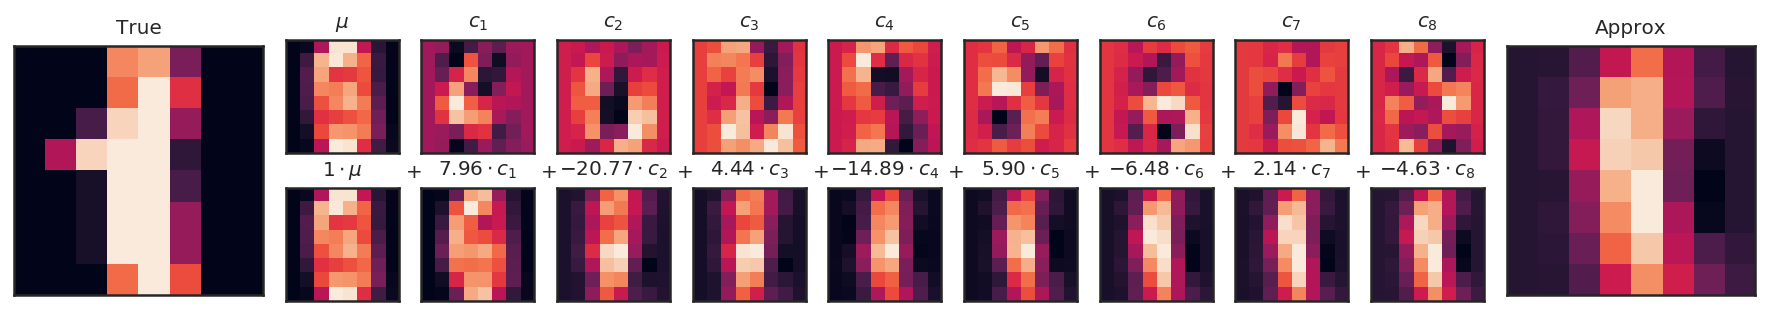

In [0]:
pca = RandomizedPCA(n_components=8)
Xproj = pca.fit_transform(digits.data)
sns.set_style('white')
fig = plot_pca_components(digits.data[1], Xproj[1], pca.mean_, pca.components_)

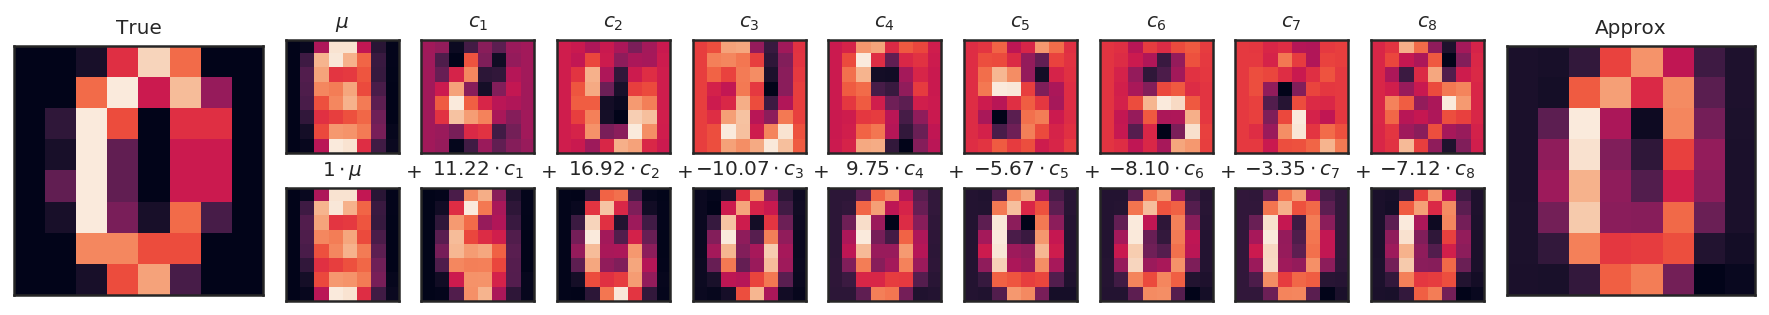

In [0]:
pca = RandomizedPCA(n_components=8)
Xproj = pca.fit_transform(digits.data)
sns.set_style('white')
fig = plot_pca_components(digits.data[10], Xproj[10], pca.mean_, pca.components_)

- It appears that the second component is the most useful for discriminating between a $0$ from a $1$ with a value $16.92 \cdot c_2$ at the zero digit and a $-20.77 \cdot c_2$ value at the one's digit. This represents the greatest variation between the two.

- Recall what these components mean: the full data is a $64$-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.

- Essentially, we have found the optimal stretch and rotation in $64$-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

### What do the components mean?

We can go a bit further here, and begin to ask what the reduced dimensions ***mean***.
This meaning can be understood in terms of combinations of basis vectors.
For example, each image in the training set is defined by a collection of $64$ pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

One way we can think about this is in terms of a pixel basis.
That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors.
For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly $90\%$ of the pixels!

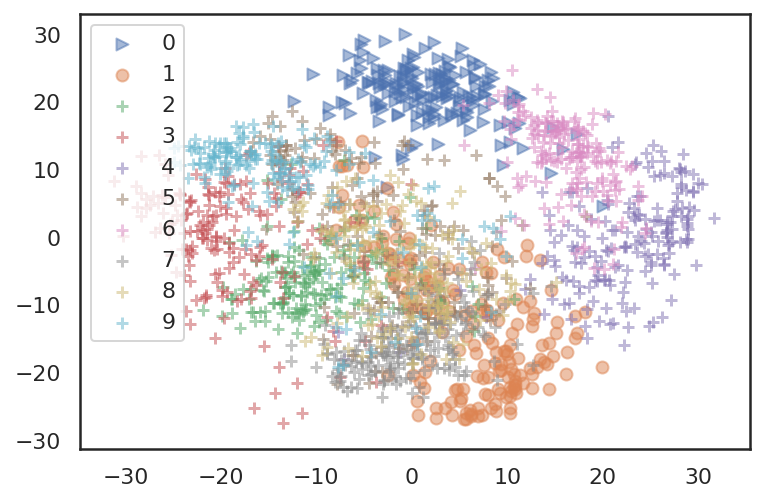

In [0]:
pca = RandomizedPCA(n_components=5)
X_pca = pca.fit_transform(X)
X_pca.shape
markers = ['>', 'o', '+', '+', '+', '+', '+', '+', '+', '+']
for i, m in zip(np.unique(y), cycle(markers)):
    py.scatter(X_pca[y == i, 0], X_pca[y == i, 1], cmap=cm.rainbow(np.linspace(0, 1, 10)), marker=m, label=i, alpha=0.5)
_ = py.legend(loc='best')

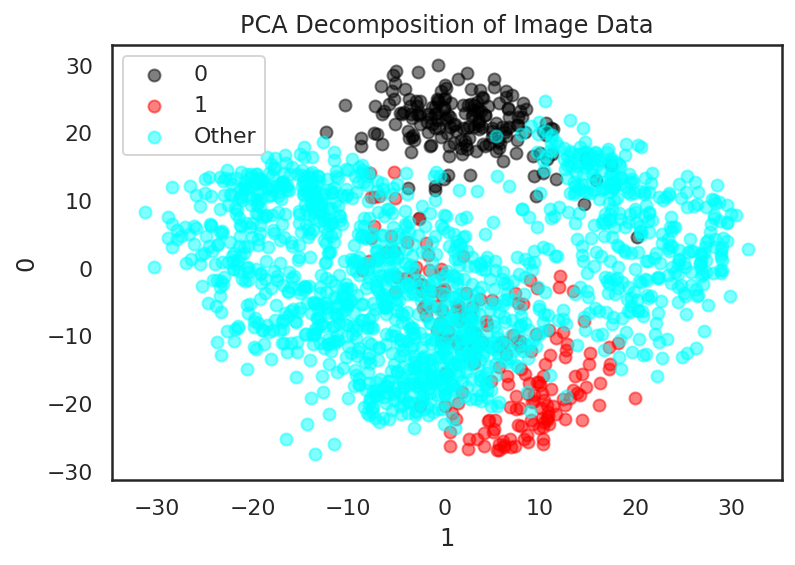

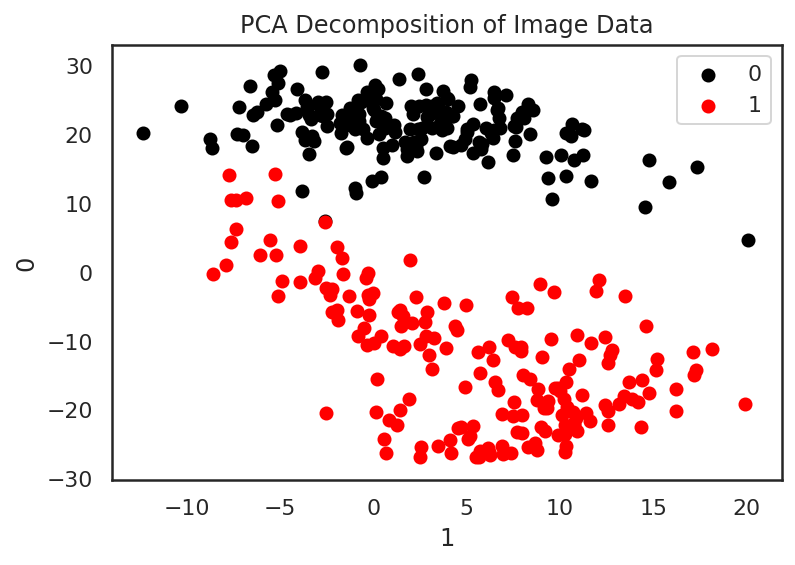

In [0]:
pca = RandomizedPCA(n_components=2)
reshaped = pca.fit_transform(X)
df = pd.DataFrame({'x': reshaped[:,0], 'y': reshaped[:, 1], 'label': np.where(y == 1, '1', np.where(y == 0, '0', 'Other'))})
for label, color in zip(df['label'].unique(), ['black', 'red', 'aqua']):
    mask = df['label'] == label
    plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label, alpha=0.5)
plt.legend()
plt.title('PCA Decomposition of Image Data')
plt.xlabel('1'), plt.ylabel('0')
plt.show()
for label, color in zip(df['label'].unique(), ['black', 'red']):
    mask = df['label'] == label
    plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label, alpha=1)
plt.title('PCA Decomposition of Image Data')
plt.xlabel('1') 
plt.ylabel('0')
_ = py.legend(loc='best')

3. **Observing compression:** Make a table with the following columns in order
  - The number of PCA components used in a compression
  - The percent an image is compressed with that many components, from $100\%$ to $0\%$. That is, the $1 - \dfrac{\text{number_of_components}}{64}$ expressed as a percentage
  - The percent variance explained in the original data by those components. This would be the cumulative sum of what was shown in step $1$.

- ModuleNotFoundError: No module named 'sklearn.cross_validation'
  - Cross selection is not active anymore. We should use instead model selection.
- https://scikit-learn.org/stable/modules/cross_validation.html
- https://stackoverflow.com/questions/30667525/importerror-no-module-named-sklearn-cross-validation



In [0]:
dims = [1,2,3,5,10,20,40,64]
comp, compress, var = [], [], []
for d in dims:
    pca = RandomizedPCA(n_components=d)
    pca.fit_transform(X)
    reduced_X = pca.transform(X[0:8])
    recovered_X = pca.inverse_transform(reduced_X)
    comp.append(d)
    compress.append(round(1-d/64,3))
    var.append(round(sum(pca.explained_variance_ratio_),3))

df = pd.DataFrame({ 
    "Number of components": comp,
    "Compression percentage (%)": compress,
    "Percent variance (%)": var
})

display(HTML(df.to_html(index=False)))

Number of components,Compression percentage (%),Percent variance (%)
1,0.984,0.149
2,0.969,0.285
3,0.953,0.403
5,0.922,0.545
10,0.844,0.738
20,0.688,0.894
40,0.375,0.988
64,0.000,1.000


4. **PCA affecting recognition accuracy:** Make a plot of the accuracy of **K nearest neighbors with $k = 1$** as the number of PCA dimensions is increased. Note: Unlike Gaussian Naive Bayes in the example, it is possible that the maximum accuracy is at $64$ dimensions.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
knn_accuracy = []
for d in range(1,64):
    pca = RandomizedPCA(n_components=d)
    pca.fit(X_train)
    tX_train = pca.transform(X_train)
    tX_test = pca.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=1)
    model = knn.fit(tX_train, y_train)
    train_score = model.score(tX_train, y_train)
    test_score = model.score(tX_test, y_test)
    y_test_pred = model.predict(tX_test)
    expected = y_test
    predicted = model.predict(tX_test)
    knn_accuracy.append(test_score)

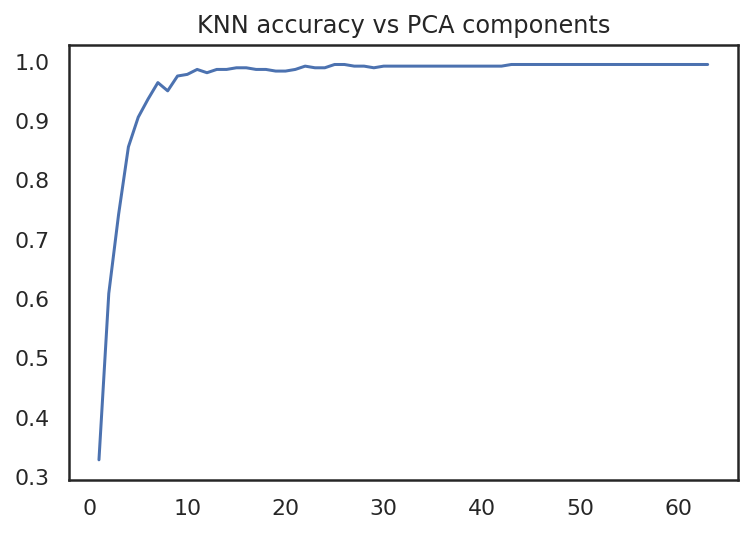

In [0]:
fig, ax = plt.subplots()
ax.set_title('KNN accuracy vs PCA components')
ax.plot(range(1,64), knn_accuracy)
plt.show()